In [1]:
import numpy as np
import pandas as pd

import pystan
import arviz

import matplotlib.pyplot as plt

In [2]:
smoking_data = pd.read_table("../utilities_and_data/smoking/smoke_pub.dat")

In [3]:
smoking_data["mean_waves_smoked"] = smoking_data.groupby("newid")["smkreg"].transform("mean")
# never_smokers = smoking_data["mean_waves_smoked"] == 0
# always_smokers = smoking_data["mean_waves_smoked"] == 1

never_smokers_test_statistic_y = (smoking_data.groupby("newid")["smkreg"].agg("mean") == 0).mean()
always_smokers_test_statistic_y = (smoking_data.groupby("newid")["smkreg"].agg("mean") == 1).mean()

In [77]:
def is_incident_smoker(arr):
    arr = arr.values
    if len(arr) == 1:
        return False
    if arr[0] == 1:
        return False
    try:
        first_idx = np.argwhere(arr == 1)[0][0]
        return np.mean(arr[first_idx:len(arr)]) == 1
    except IndexError as ex:
        return False

In [84]:
incident_smokers_test_statistic_y = np.mean(smoking_data.groupby("newid")["smkreg"].agg(is_incident_smoker))

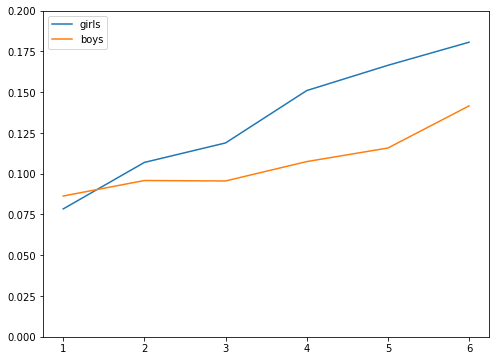

In [62]:
fig, ax = plt.subplots(figsize=(8, 6))
ax.plot(smoking_data.loc[smoking_data["sex(1=F)"] == 1].groupby("wave")["smkreg"].mean(), label="girls");
ax.plot(smoking_data.loc[smoking_data["sex(1=F)"] == 0].groupby("wave")["smkreg"].mean(), label="boys");
ax.set_ylim(0, 0.2);
ax.legend();

In [63]:
num_people = smoking_data["newid"].nunique()

In [64]:
model = pystan.StanModel("model.stan")

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_464947f85f6b4f3d68824aec3d50eef4 NOW.


In [65]:
stan_data = {
    "N_people": num_people,
    "N": len(smoking_data),
    "parent_smoke": smoking_data["parsmk"],
    "female": smoking_data["sex(1=F)"],
    "t": smoking_data["wave"],
    "smoke": smoking_data["smkreg"],
    "p_idx": smoking_data["newid"]
}

In [66]:
fit = model.sampling(stan_data, iter=1000)

To run all diagnostics call pystan.check_hmc_diagnostics(fit)


In [67]:
params = fit.extract(permuted=True)
var_names=["b0", "b1", "b2", "b3", "b4", "sigma_alpha"]

In [68]:
inference_data = arviz.convert_to_inference_data(fit)
summary_df = (
    arviz.summary(inference_data, var_names=var_names)
    .reset_index()
    .rename(columns={"index": "parameter"})
)

In [69]:
summary_df.head(10)

,parameter,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
0,b0,-8.542,0.510,-9.446,-7.532,0.020,0.014,628.0,628.0,624.0,1367.0,1.01
1,b1,2.560,0.364,1.831,3.221,0.015,0.011,571.0,571.0,572.0,959.0,1.00
2,b2,-0.423,0.456,-1.302,0.384,0.015,0.011,912.0,912.0,916.0,1281.0,1.00
3,b3,0.355,0.056,0.255,0.465,0.001,0.001,3168.0,3101.0,3170.0,1452.0,1.00
4,b4,0.529,0.054,0.436,0.638,0.001,0.001,3747.0,3685.0,3756.0,1391.0,1.00
5,sigma_alpha,5.011,0.281,4.464,5.507,0.010,0.007,722.0,722.0,719.0,1365.0,1.01


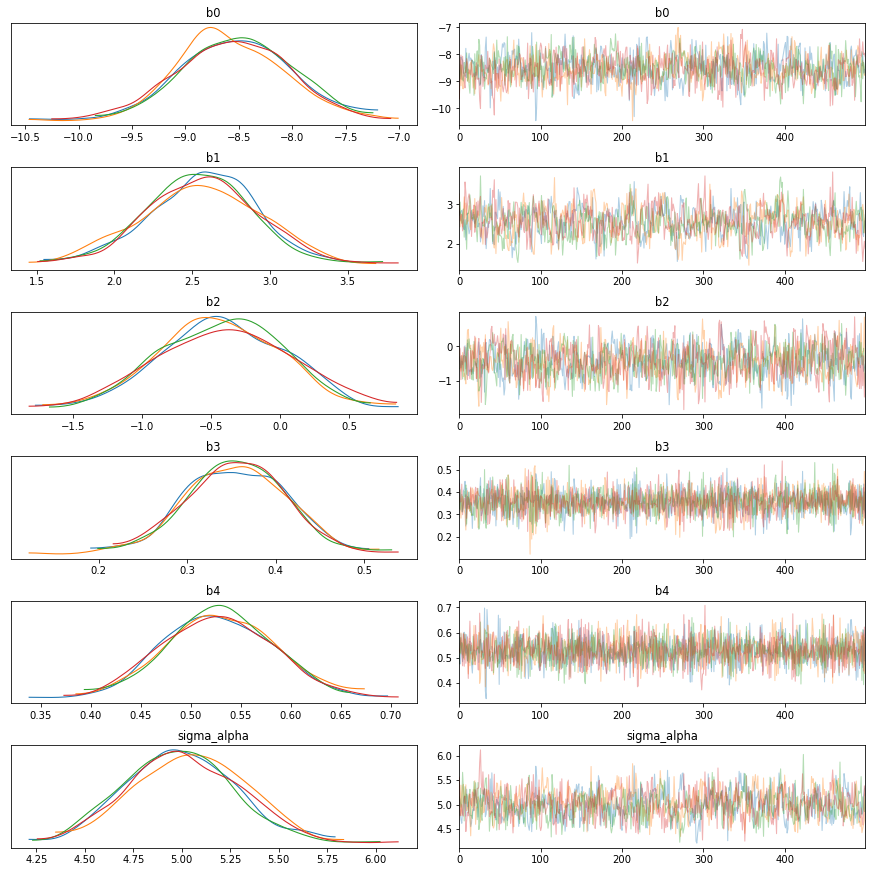

In [70]:
arviz.plot_trace(fit, var_names=var_names);

In [71]:
df_y_rep = pd.DataFrame(params["y_pred"]).T
df_y_rep["newid"] = smoking_data["newid"].values

In [72]:
never_smokers_y_rep = df_y_rep.groupby("newid").sum().values
never_smokers_test_statistic = (never_smokers_y_rep == 0).mean(0)
qs = np.quantile(never_smokers_test_statistic, q=[0.025, 0.975])

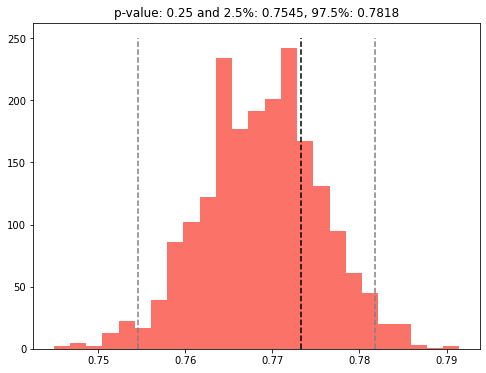

In [73]:
fig, ax = plt.subplots(figsize=(8, 6))
ax.hist(never_smokers_test_statistic, bins=25, color="#fa7268");
ax.vlines(qs[0], 0, 250, linestyle="--", color="grey");
ax.vlines(qs[1], 0, 250, linestyle="--", color="grey");
ax.vlines(never_smokers_test_statistic_y, 0, 250, linestyle="--", label="$T(y)$");
ax.set_title(f"p-value: {(np.mean(never_smokers_test_statistic > never_smokers_test_statistic_y)):.2f} and 2.5%: {qs[0]:.4f}, 97.5%: {qs[1]:.4f}");

In [74]:
always_smokers_y_rep = df_y_rep.groupby("newid").mean().values
always_smokers_test_statistic = (always_smokers_y_rep == 1).mean(0)
qs = np.quantile(always_smokers_test_statistic, q=[0.025, 0.975])

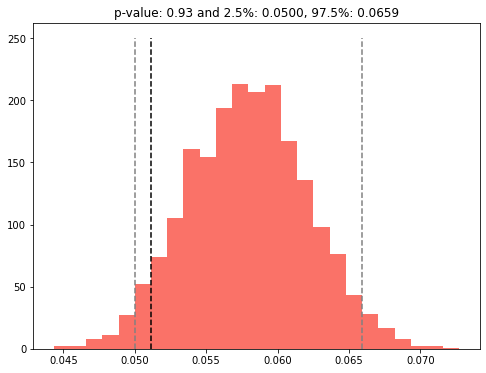

In [75]:
fig, ax = plt.subplots(figsize=(8, 6))
ax.hist(always_smokers_test_statistic, bins=25, color="#fa7268");
ax.vlines(qs[0], 0, 250, linestyle="--", color="grey");
ax.vlines(qs[1], 0, 250, linestyle="--", color="grey");
ax.vlines(always_smokers_test_statistic_y, 0, 250, linestyle="--", label="$T(y)$");
ax.set_title(f"p-value: {(np.mean(always_smokers_test_statistic > always_smokers_test_statistic_y)):.2f} and 2.5%: {qs[0]:.4f}, 97.5%: {qs[1]:.4f}");

In [85]:
df_y_rep.head()

,0,1,2,3,4,5,6,7,8,9,...,1991,1992,1993,1994,1995,1996,1997,1998,1999,newid
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
4,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1


In [ ]:
ts = []
for i in range(params["y_pred"].shape[0]):
    tmp_df = pd.DataFrame({"smkreg": params["y_pred"][i], "newid": df_y_rep["newid"]})
    ts.append(np.mean(tmp_df.groupby("newid")["smkreg"].agg(is_incident_smoker2)))

In [81]:
np.quantile(ts, q=[0.025, 0.975])

array([0.05284091, 0.07897727])

In [82]:
np.mean(np.array(ts) > incident_smokers_test_statistic_y)

0.005

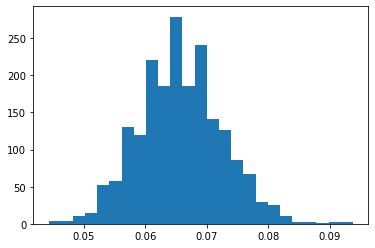

In [83]:
plt.hist(ts, bins=25);